In [1]:
# TODO
# 1: ColorLine -> DONE
# 2: Make plots of highway/surface/tracktype -> DONE
# 3: Determine paved status rules -> DONE
# 4: Determine city names
# 5: Fix double pathing
# 6: Merge data into single file
# 7: Build separate analysis script
# 8: Make plots: percentage paved vs. unpaved, length of individual paved/unpaved sections

# Other ideas
# Figure out how to plot: closest town, topography type (forest, plains, etc.), elevation profile

In [2]:
# Preamble
from IPython.display import IFrame
from itertools import groupby 
from csv import writer
import networkx as nx
import pandas as pd
import numpy as np
import osmnx as ox
import warnings
import folium
import branca.colormap as cm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/svanwal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
# --- Load and process the GPX track
trail = 'gr131'
# trail = 'gr16'
points_per_batch = 100
filename_in = 'data/' + trail + '.csv'
hike = pd.read_csv(filename_in)
coords = hike[['latitude','longitude']].values.tolist()
n_batch = int(np.ceil(hike.shape[0]/points_per_batch))

In [5]:
filename = 'data/' + trail + '_0to' + str(points_per_batch) + '.csv'
df = pd.read_csv(filename,dtype={'surface': str})

In [6]:
# Loading data and merging
for b in range(1,n_batch): # b is the batch counter
    n1 = b*points_per_batch # First point
    n2 = min(n1 + points_per_batch, len(hike)) # Last point
    filename = 'data/' + trail + '_' + str(n1) + 'to' + str(n2) + '.csv'
    df_new = pd.read_csv(filename,dtype={'surface': str})
    df = pd.concat([df,df_new],ignore_index=True)

## Counting highway/surface/tracktype

In [7]:
def grab_first(x):
    if x is not None:
        bb = x.strip('][')
        cc = bb.split(',')
        dd = [element.strip().strip("'") for element in cc]
        return dd[0]
    return x

In [8]:
df['highway'] = df['highway'].replace({np.nan:"none"})
df['surface'] = df['surface'].replace({np.nan:"none"})
df['tracktype'] = df['tracktype'].replace({np.nan:"none"})

In [9]:
df['first_highway'] = df['highway'].apply(grab_first)
df['first_surface'] = df['surface'].apply(grab_first)
df['first_tracktype'] = df['tracktype'].apply(grab_first)

## Defining paved status

In [10]:
def get_paved_status(row):
    tracktype_paved = ['grade1']
    tracktype_unpaved = ['grade2','grade3','grade4','grade5']
    surface_unpaved = ['ground','gravel','grass','unpaved','fine_gravel','wood','dirt','compacted','sand','rock','pebblestone','earth','mud','woodchips','snow','ice','salt']
    highway_unpaved = ['track','path','footway','bridleway']
    
    if row['first_tracktype'] in tracktype_unpaved:
        return False
    elif row['first_tracktype'] in tracktype_paved:
        return True
    else:
        if row['surface'] in surface_unpaved:
            return False
        else:
            if row['highway'] in highway_unpaved:
                return False
            else:
                return True

In [11]:
df['paved'] = df.apply(get_paved_status,axis=1)

## Analyzing statistics

In [12]:
# Paved and unpaved sections
tot_unpaved = df[~df['paved']]['d_cart'].sum()
tot_paved = df[df['paved']]['d_cart'].sum()
tot = tot_unpaved + tot_paved
print(f'Percentage paved: {round(tot_paved/tot,3)}')
print(f'Percentage unpaved: {round(tot_unpaved/tot,3)}')

Percentage paved: 0.681
Percentage unpaved: 0.319


In [15]:
# Figuring out delta_d
df['d_cum'] = df['d_cart'].cumsum()
df['d0'] = df['d_cum'].shift(1)
df.loc[0,'d0'] = 0
df['d1'] = df['d_cum']

## Plotting the route

In [16]:
# Set up ColorLine data
x = df['x0'].values.tolist()
y = df['y0'].values.tolist()
x.extend(df.tail(1)['x1'])
y.extend(df.tail(1)['y1'])
colors = df['paved'].values.tolist()
colors[colors==True] = 1
colors[colors==False] = 0
xy0 = list(zip(x,y))
xy = [[coord[0],coord[1]] for coord in xy0]
colormap = cm.LinearColormap(colors=['#239621','black'],vmin=0.25,vmax=0.75,index=[0.25,0.75])

In [17]:
# Map setup
mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") 
   
# Draw matched route segments
newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
newline.add_to(chart)

# Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Drawing successive segments

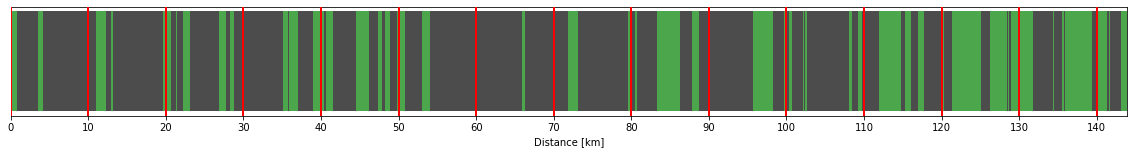

In [18]:
fig, ax = plt.subplots(figsize=(20,2))
plt.rc('font', size=20)
for idx, row in df.iterrows():
    x = [row['d0']/1000,row['d1']/1000]
    y = [1,1]
    if row['paved']:
        plt.plot(x,y,linewidth=100,color='black',solid_capstyle='butt',alpha=0.7)
    else:
        plt.plot(x,y,linewidth=100,color='green',solid_capstyle='butt',alpha=0.7)
plt.xticks(np.arange(0, 1000, step=10))
plt.yticks([])
plt.xlabel('Distance [km]')
plt.xlim(0,df['d1'].loc[df.shape[0]-1]/1000)
ax.set_axisbelow(False)
plt.grid(visible=True,axis='x',alpha=1,color='red',linewidth=2)

plt.show()

In [ ]:
# 

In [12]:
pd.set_option('display.max_rows', None)
# print(df.groupby(['first_highway','first_surface'])['first_tracktype'].value_counts(dropna=False))
# print(df.groupby(['first_highway','first_tracktype'])['first_surface'].value_counts(dropna=False))
print(df.groupby(['first_tracktype','first_surface'])['first_highway'].value_counts(dropna=False))
pd.reset_option('display.max_rows')

first_tracktype  first_surface    first_highway
grade1           asphalt          track              12
                 concrete         unclassified        9
                 grass            track              18
                                  unclassified       12
                 none             unclassified        2
                 paved            unclassified        6
grade2           fine_gravel      track              27
                 gravel           track               1
grade3           asphalt          unclassified       23
                 ground           path               36
                                  track               5
                 none             track              11
                                  service             2
grade4           compacted        track               2
                 grass_paver      track              58
                 none             track              15
grade5           grass            track               5


## Plotting some weird ones

In [50]:
# grade3 asphalt unclassified
# mask_grade = df['first_tracktype']=='grade3'
# mask_surface = df['first_surface']=='asphalt'
# mask_highway = df['first_highway']=='unclassified'
# mask_tot = mask_grade & mask_surface & mask_highway

# bridleway
mask_highway = df['first_highway']=='bridleway'
mask_tot = mask_highway

# grade1
mask_grade = df['first_tracktype']=='grade1'
mask_tot = mask_grade

subset = df[mask_tot]

# Trying out ColorLine
# x = subset['x0'].values.tolist()
# y = subset['y0'].values.tolist()
# x.extend(df.tail(1)['x1'])
# y.extend(df.tail(1)['y1'])
# xy0 = list(zip(x,y))
# xy = [[coord[0],coord[1]] for coord in xy0]

# colormap = cm.LinearColormap(colors='black',vmin=0.25,vmax=0.75,index=[0.25,0.75])

mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") # Map setup
    
# newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
# newline.add_to(chart)
    
for idx, row in subset.iterrows():
    c = [[row['x0'],row['y0']],
         [row['x1'],row['y1']]]
    newline = folium.PolyLine(locations=c, color='red', weight=5, popup='None')
    newline.add_to(chart)

# # Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Drafts

In [175]:
pd.set_option('display.max_rows', None)
print(df['first_highway'].value_counts(dropna=False))
pd.reset_option('display.max_rows')

unclassified    2358
path             620
track            452
footway          251
residential      230
cycleway         175
tertiary         147
service          111
steps             23
secondary         18
primary           14
pedestrian        10
bridleway          4
Name: first_highway, dtype: int64


In [166]:
pd.set_option('display.max_rows', None)
print(df.groupby('first_highway')['first_surface'].value_counts(dropna=False))
pd.reset_option('display.max_rows')

first_highway  first_surface  
bridleway      none                  4
cycleway       asphalt             109
               gravel               23
               none                 23
               concrete             11
               unpaved               9
footway        fine_gravel          99
               none                 78
               gravel               46
               asphalt              10
               concrete              7
               paved                 3
               paving_stones         3
               wood                  3
               concrete:plates       2
path           none                219
               grass               128
               unpaved             106
               ground               83
               asphalt              33
               wood                 21
               fine_gravel          16
               compacted            13
               sand                  1
pedestrian     none              

first_highway  first_tracktype
bridleway      none                  4
cycleway       none                175
footway        none                251
path           none                581
               grade3               36
               grade5                3
pedestrian     none                 10
primary        none                 14
residential    none                230
secondary      none                 18
service        none                109
               grade3                2
steps          none                 23
tertiary       none                147
track          none                268
               grade4               75
               grade5               35
               grade1               30
               grade2               28
               grade3               16
unclassified   none               2306
               grade1               29
               grade3               23
Name: first_tracktype, dtype: int64


In [171]:
pd.set_option('display.max_rows', None)
print(df.groupby(['first_highway','first_surface'])['first_tracktype'].value_counts(dropna=False))
pd.reset_option('display.max_rows')

first_highway  first_surface    first_tracktype
bridleway      none             none                  4
cycleway       asphalt          none                109
               concrete         none                 11
               gravel           none                 23
               none             none                 23
               unpaved          none                  9
footway        asphalt          none                 10
               concrete         none                  7
               concrete:plates  none                  2
               fine_gravel      none                 99
               gravel           none                 46
               none             none                 78
               paved            none                  3
               paving_stones    none                  3
               wood             none                  3
path           asphalt          none                 33
               compacted        none                 13


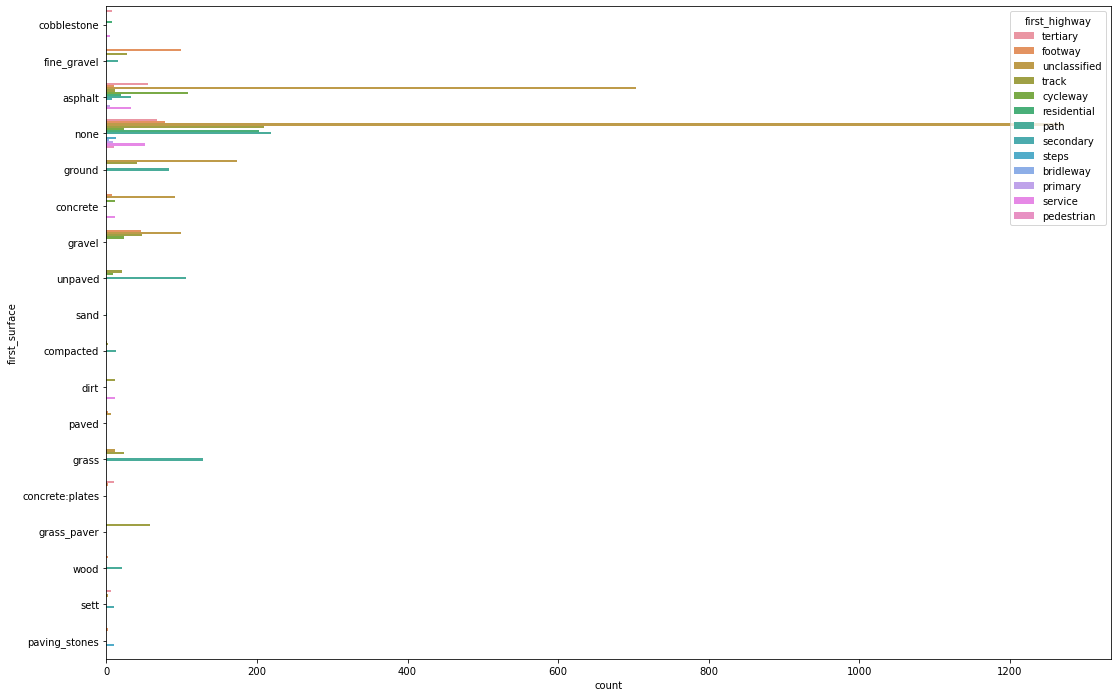

In [163]:
# sns.countplot(data=df,y='first_highway',hue='first_surface')
fig, ax = plt.subplots(figsize=(18, 12))
sns.countplot(data=df,y='first_surface',hue='first_highway')
plt.show()

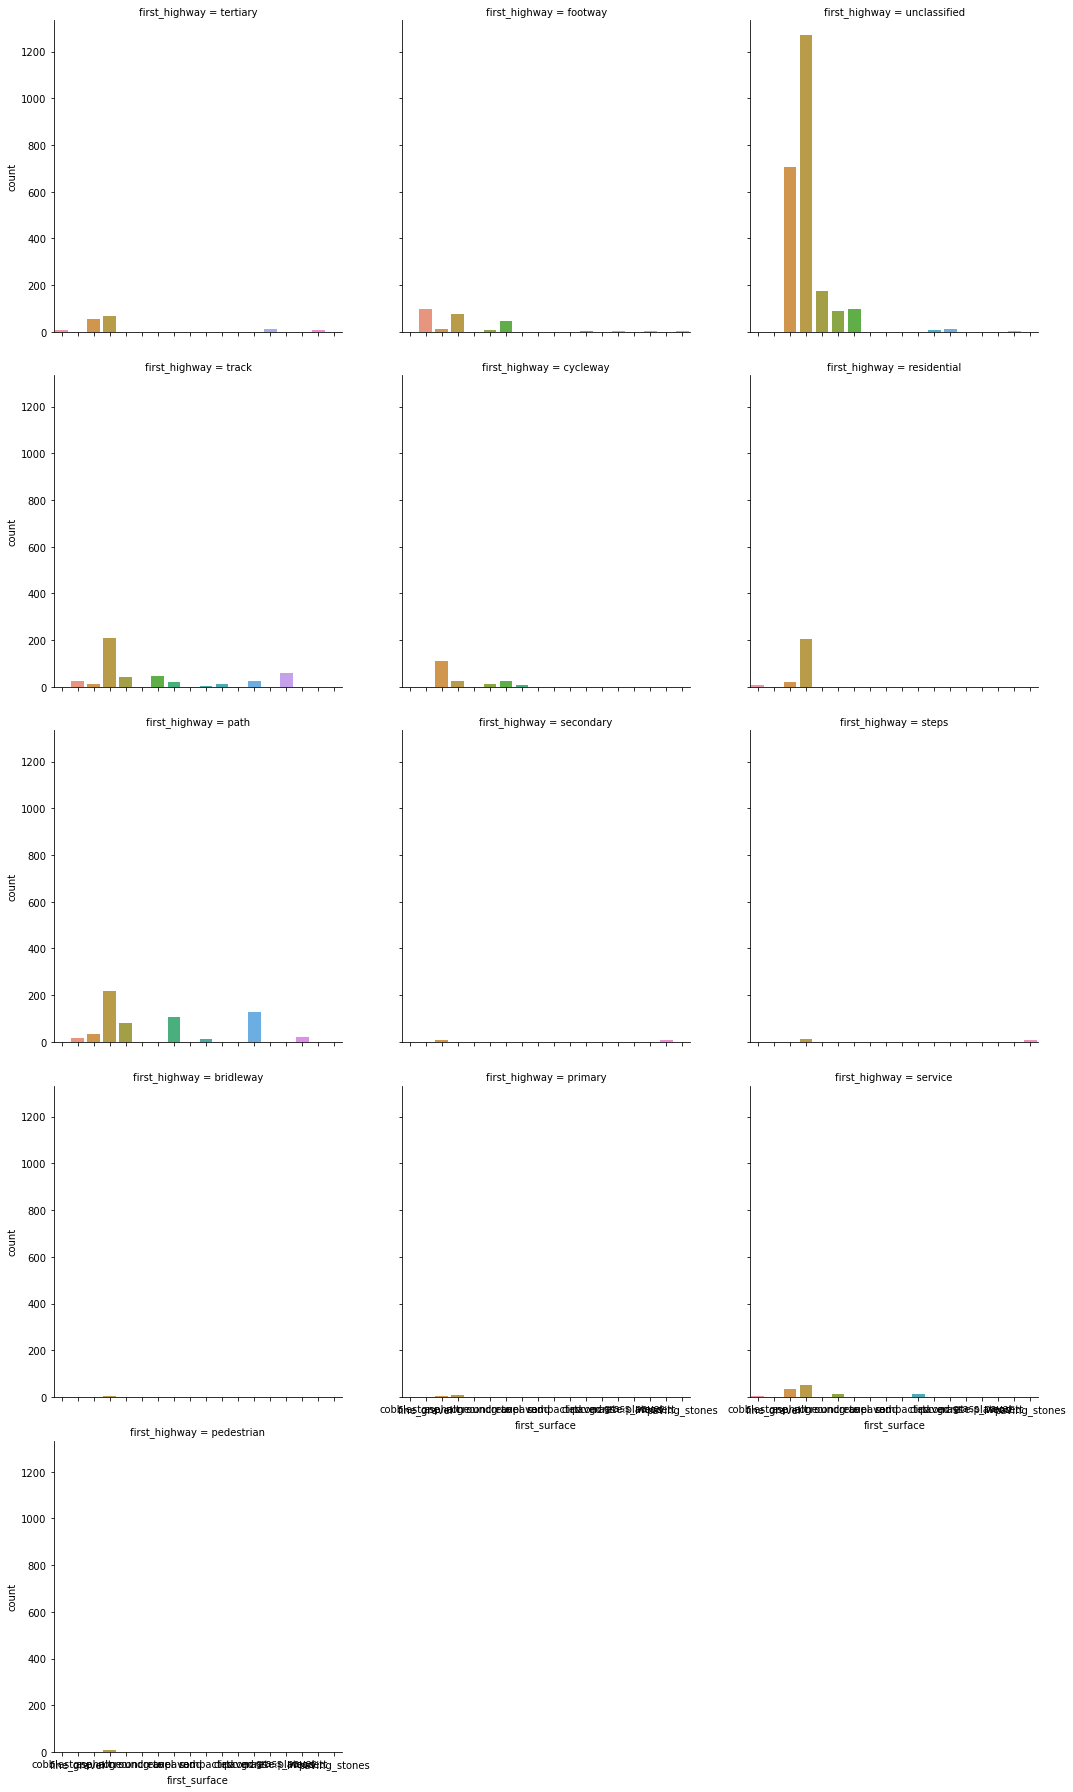

In [145]:
sns.catplot(data=df,x='first_surface',col='first_highway',kind='count',col_wrap=3, orient='h')

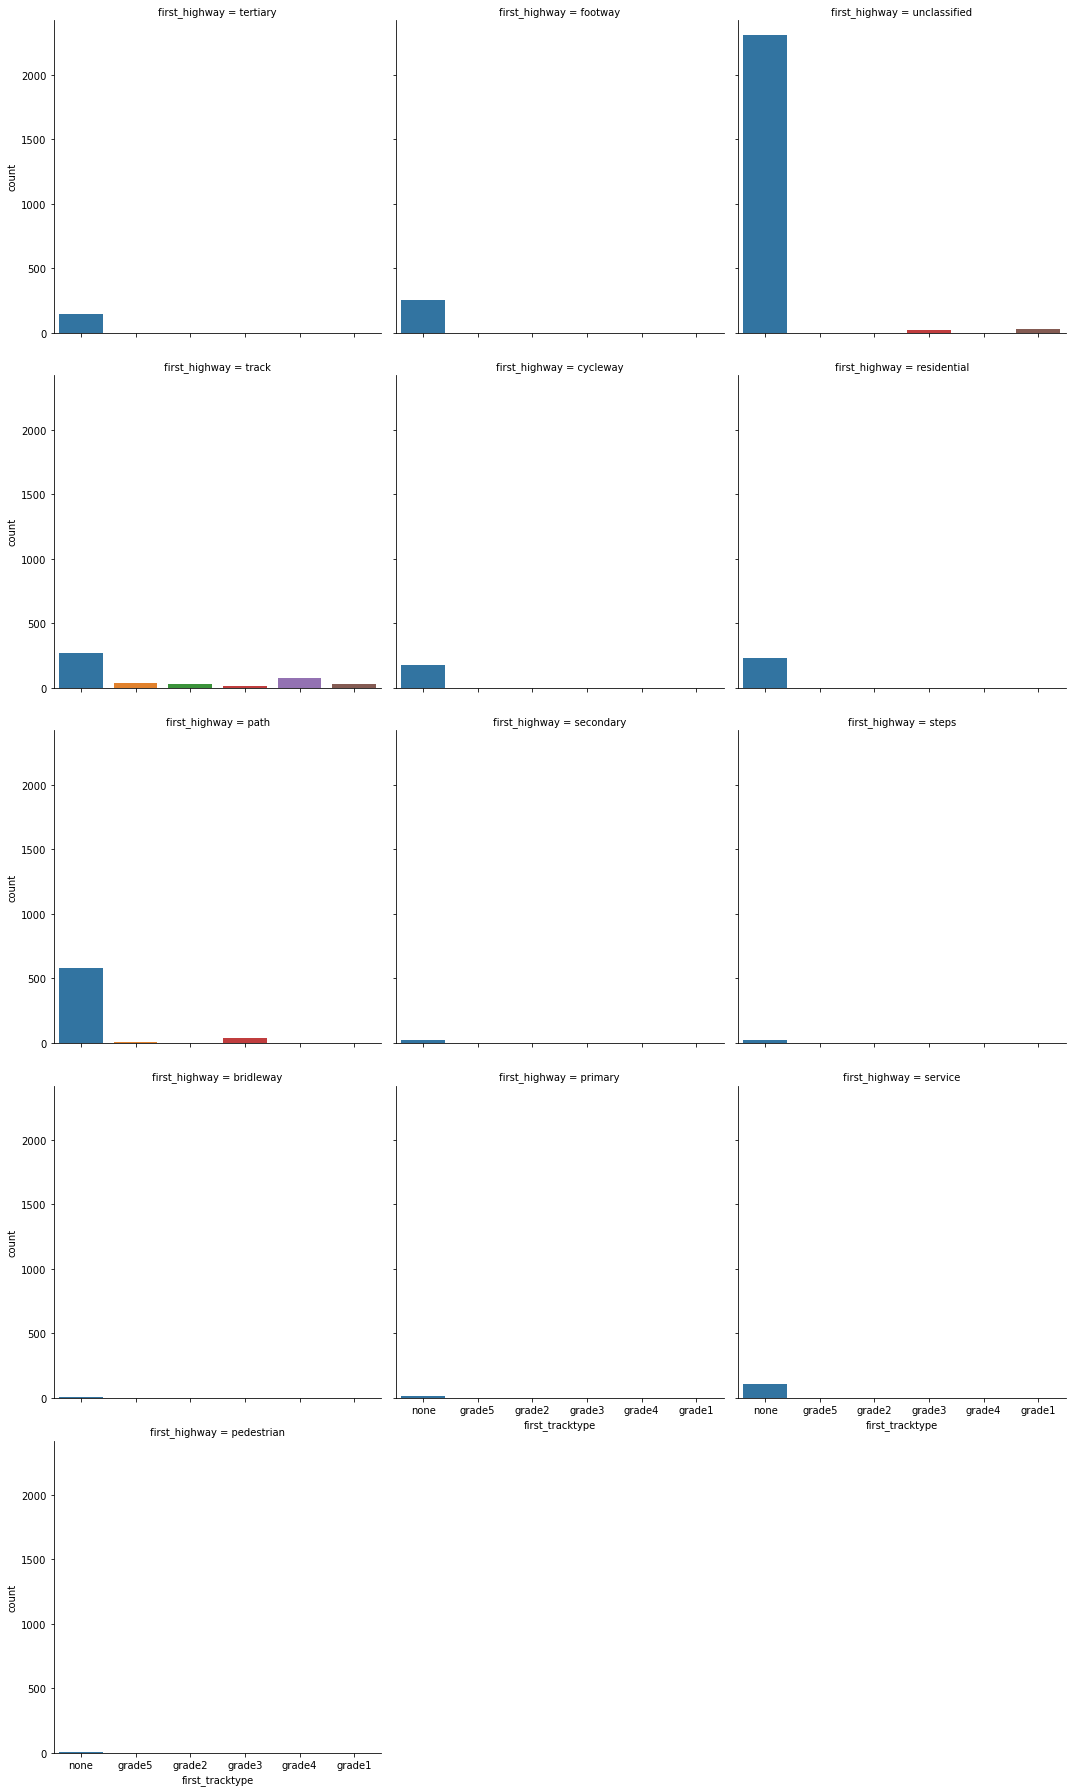

In [141]:
sns.catplot(data=df,x='first_tracktype',col='first_highway',kind='count',col_wrap=3)

## Statistics

In [10]:
mask_highway = df['highway'].isin(['track','path','footway'])
mask_tracktype = df['tracktype'].isin(['grade1','grade2','grade3','grade4','grade5'])

In [11]:
# df[mask_highway]['surface'].value_counts()
# df['tracktype'].value_counts()
# df['highway'].value_counts()
df['surface'].value_counts()

asphalt                                  1688
gravel                                    430
ground                                    360
grass                                     326
fine_gravel                               248
concrete                                  224
['unpaved', 'grass']                      204
grass_paver                               116
['asphalt', 'gravel']                     110
['ground', 'wood', 'asphalt']              82
['ground', 'wood', 'grass', 'gravel']      72
unpaved                                    68
['asphalt', 'concrete:lanes']              54
['asphalt', 'concrete']                    50
['wood', 'grass', 'gravel']                42
sett                                       36
compacted                                  32
['ground', 'gravel']                       32
['ground', 'gravel', 'sand']               30
cobblestone                                26
paving_stones                              26
['dirt', 'gravel']                

In [154]:
def grab_first(x):
    print(x)
    bb = x.strip('][')
    cc = bb.split(',')
    dd = [element.strip().strip("'") for element in cc]
    return dd[0]


df['first_surface'] = df['surface'].apply(grab_first)
df['first_surface'].value_counts()
# aa = df.loc[100]['surface']
# bb = aa.strip('][')
# cc = bb.split(',')
# dd = [element.strip().strip("'") for element in cc]
# print(dd[1])
# dd[0] = cc[0].strip().strip("'")
# dd[1] = cc[1].strip().strip("'")
# print(dd[0])
# print(dd[1])
# print(dd)
# print(type(dd))

['cobblestone', 'sett']
['cobblestone', 'sett']
['cobblestone', 'sett']
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
fine_gravel
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt
asphalt


AttributeError: 'float' object has no attribute 'strip'

In [54]:
df2 = df.highway.str.split(',').apply(pd.Series)          # break df.asn into columns
df2.index = df.index                                   # set the index as df.Name
df2 = df2.stack().reset_index()                 # stack and reset_index
df2

,level_0,level_1,0
0,0,0,tertiary
1,1,0,tertiary
2,2,0,tertiary
3,3,0,footway
4,4,0,footway
...,...,...,...
4891,4163,0,track
4892,4164,0,track
4893,4165,0,track
4894,4166,0,track


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4168 entries, 0 to 4167
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   x0              4168 non-null   object
 1   y0              4168 non-null   object
 2   x1              4168 non-null   object
 3   y1              4168 non-null   object
 4   d_cart          4168 non-null   object
 5   d_osm           4168 non-null   object
 6   highway         4168 non-null   object
 7   surface         2141 non-null   object
 8   tracktype       277 non-null    object
 9   single_highway  4168 non-null   object
 10  first_highway   4168 non-null   object
dtypes: object(11)
memory usage: 358.3+ KB


In [28]:
a = ['dfsgfcsg','ewrewrw']
b = 'asfdgdsg'

In [33]:
type(b)

str

<AxesSubplot:ylabel='Frequency'>

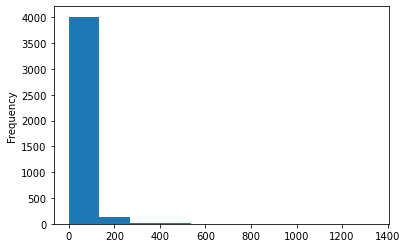

In [8]:
df['d_cart'].plot(kind='hist')

## Plotting GPX track versus OSM route

In [169]:
# Trying out ColorLine
df['paved'] = df['highway'].isin(['track','path'])
x = df['x0'].values.tolist()
y = df['y0'].values.tolist()
x.extend(df.tail(1)['x1'])
y.extend(df.tail(1)['y1'])
colors = df['paved'].values.tolist()
colors[colors==True] = 1
colors[colors==False] = 0
xy0 = list(zip(x,y))
xy = [[coord[0],coord[1]] for coord in xy0]

colormap = cm.LinearColormap(colors=['black','#239621'],vmin=0.25,vmax=0.75,index=[0.25,0.75])

In [170]:
mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") # Map setup
    
newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
newline.add_to(chart)
    
# newline = folium.PolyLine(locations=coords, color='red', weight=1, popup='None')
# newline.add_to(chart)

# Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

In [171]:
mask_trackpath = df['highway'].isin(['track','path'])
tot_unpaved = df[mask_trackpath]['d_cart'].sum()
tot_paved = df[~mask_trackpath]['d_cart'].sum()
tot = tot_unpaved + tot_paved
print(f'Percentage paved: {tot_paved/tot}')
print(f'Percentage unpaved: {tot_unpaved/tot}')
df['tracktype'].value_counts()

Percentage paved: 0.380817037454142
Percentage unpaved: 0.6191829625458579


grade3                  2181
grade2                  1587
grade1                   966
grade4                   783
grade5                   648
['grade4', 'grade3']      93
['grade3', 'grade5']      36
['grade1', 'grade2']      36
['grade3', 'grade1']      27
Name: tracktype, dtype: int64